In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\Ouissal\NLP--from-scratch-with-Pytorch\venv\Lib\site-packages\torch\_subclasses\functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:81.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


'cpu'

### Data preparation

#### 1. From unicode to ASCII

In [2]:
import string
import unicodedata

# "_" represents an out-of-vocabulary character
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

example of usage: 

In [3]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


#### 2. Names to tensors

In [4]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):

    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [8]:
print("a => index:  ", letterToIndex('a'))
print("a => tensor: ", lineToTensor('a')) 
print("ouissal => tensor size: ", lineToTensor('ouissal').size()) # (line_length, 1, n_letters)

a => index:   0
a => tensor:  tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
ouissal => tensor size:  torch.Size([7, 1, 58])


#### 3. Dataset creation

Each Dataset needs to implement three functions: `__init__`, `__len__`, and `__getitem__`

In [9]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

In [ ]:
class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir 
        self.load_time = time.localtime
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = [] # labels of each sample in dataset
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long) #dtype must be long for our loss function like CrossEntropyLoss
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [15]:
alldata = NamesDataset("../data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([4]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 

#### 4. Train & test data

In [16]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(42))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


### Creating the Network

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_output, hidden = self.rnn(line_tensor)
        output = self.linear(hidden[0])
        output = self.softmax(output)
        return output

In [19]:
NUM_HIDDEN = 128
NUM_CLASSES = len(alldata.labels_uniq)
model = CharRNN(n_letters, NUM_HIDDEN, NUM_CLASSES).to(device)
model

CharRNN(
  (rnn): RNN(58, 128)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

### Training

In [23]:
import random
import numpy as np
from tqdm.auto import tqdm

c:\Users\Ouissal\NLP--from-scratch-with-Pytorch\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
y_pred_0 = model(train_set[0][1])

In [ ]:
y_pred_0

tensor([[-2.8819, -2.8577, -2.8632, -2.7724, -2.9716, -3.0124, -2.9871, -2.7888,
         -2.7689, -2.8022, -2.8902, -2.9223, -2.9330, -2.8923, -2.8549, -2.9736,
         -3.0106, -2.8960]], grad_fn=<LogSoftmaxBackward0>)

In [26]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr = 1e-4
)

In [29]:
NUM_EPOCHS = 10
for epoch in tqdm(range(NUM_EPOCHS)):
    model.to(device)
    model.train()
    train_loss = 0.0
    all_losses = []
    correct_preds = 0
    total_samples = 0
    
    for y, X, _, _ in train_set:
        X, y = X.to(device), y.to(device)  # move data to device
        
        # forward pass
        y_pred = model(X)  # logits
        loss = loss_function(y_pred, y)
        
        # track loss
        train_loss += loss.item()
        all_losses.append(loss.item())
        
        # track accuracy
        preds = torch.argmax(y_pred, dim=1)
        correct_preds += (preds == y).sum().item()
        total_samples += y.size(0)
        
        # optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 2 == 0:
        avg_loss = train_loss / len(train_set)
        accuracy = correct_preds / total_samples
        print(f"{epoch}({epoch/NUM_EPOCHS:.0%}) | loss: {avg_loss:.4f} | acc: {accuracy:.2%}")


 10%|█         | 1/10 [01:04<09:42, 64.78s/it]

0(0%) | loss: 2.1348 | acc: 44.82%


 30%|███       | 3/10 [02:33<05:43, 49.01s/it]

2(20%) | loss: 1.7382 | acc: 47.07%


 50%|█████     | 5/10 [03:58<03:46, 45.36s/it]

4(40%) | loss: 1.6497 | acc: 50.45%


 70%|███████   | 7/10 [05:25<02:12, 44.21s/it]

6(60%) | loss: 1.5794 | acc: 52.33%


 90%|█████████ | 9/10 [06:52<00:43, 43.94s/it]

8(80%) | loss: 1.5146 | acc: 54.36%


100%|██████████| 10/10 [07:41<00:00, 46.14s/it]


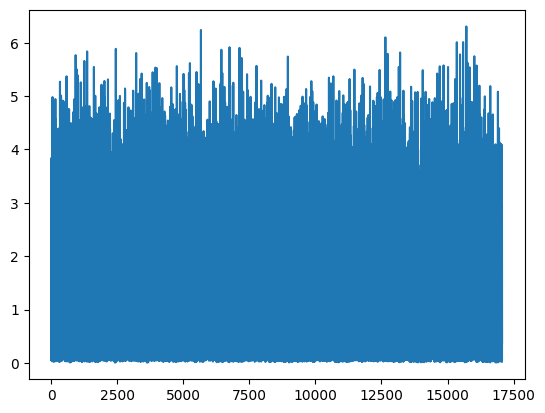

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### Evaluation